# Project - Regressors

## Initialization

Import libraries

In [1]:
import glob
import os

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import log_loss, r2_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_fscore_support, precision_recall_curve, auc

from operator import itemgetter, attrgetter

from matplotlib import pyplot as plt

#### Prepare parallel kernel

*Install [here](https://ipyparallel.readthedocs.io/en/latest/), define the number of engines and click '**Start**' in the* **iPython Clusters** *tab.*

Import parallel computing libraries and register processors

In [2]:
from ipyparallel import Client
from ipyparallel.joblib import IPythonParallelBackend
from joblib import Parallel, parallel_backend, register_parallel_backend

On Noto, run `ipcontroller --ip="*"`

In [3]:
c = Client(profile='default')
print('profile:', c.profile)
print("IDs:", c.ids) # Process id numbers
bview = c.load_balanced_view()
register_parallel_backend('ipyparallel',
                          lambda : IPythonParallelBackend(view=bview))

profile: default
IDs: [0, 1, 2, 3]


/Users/Christopher/anaconda3/lib/python3.7/site-packages/ipyparallel/util.py:214: RuntimeWarning: IPython could not determine IPs for MBPdeChistopher: [Errno 8] nodename nor servname provided, or not known
  RuntimeWarning)


---

## Function definitions

Read datasets

In [4]:
def plot_importance(feature_importance_sorted, n, type_of_search):
    
    plt.figure(figsize=(15,5))
    x = np.arange(n)
    y = [feature_importance_sorted[i][1] for i in range(n)]
    labels = [feature_importance_sorted[i][0] for i in range(n)]
    ax = sns.barplot(y,x,orient="h");
    plt.xlabel("Importance fraction", fontsize = 12)
    ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
    plt.yticks(x,labels, fontsize = 15)
    plt.title('Most important feature: {}'.format(type_of_search), fontsize = 15)
    plt.show()

In [5]:
def pp_rf(test_size):
    
    list_of_files = glob.glob('50_by_100/Full*.csv') # * means all if need specific format then *.csv
    latest_file = max(list_of_files, key=os.path.getctime)
    
    print(latest_file)

    df_raw = pd.read_csv(latest_file, index_col=0)
    df_raw.sort_index(inplace = True, ascending = True)
    df_raw.sort_index(inplace = True, axis = 1)

    y = df_raw.COVID.copy()
    X = df_raw.drop(columns = ['COVID']).copy()
    
    X_types = dict(X.dtypes)
    features = list(X.columns)
    
    train = np.random.rand(len(df_raw))> test_size

    X_train = X[train]
    X_test = X[~train]

    y_train = y[train].tolist()
    y_test = y[~train].tolist()

    return X, X_train, X_test, y, y_train, y_test

## Random Forest Regressor

We will compare two methods, which are grid search and random search.

In [6]:
X, X_train, X_test, y, y_train, y_test = pp_rf(0.3)

50_by_100/Full-2020_05_10-13_14_09-X_raw_disease_50_target_100_7217_by_101.csv


In [7]:
rf_reg = RandomForestRegressor(n_jobs=-1)

### Random Search

After having explored a grid search, we can adopt another approach. Instead of searching for each value, let's give our model more parameters input, but instead let it choose randomly at each iteration one value for each parameter. It will then be evaluated again.

In [8]:
n_estimators = range(10,5000,50)
criterion = ['mse', 'mae']
max_depth = range(5,50,10)
min_samples_split = range(2,100,2)
min_samples_leaf = range(2,100, 2)
max_features = ['sqrt', 'log2', None]
bootstrap = [True,False]

random_parameters = {'n_estimators' : n_estimators,
                     'criterion' : criterion,
                     'max_depth' : max_depth,
                     'min_samples_split' : min_samples_split,
                     'min_samples_leaf' : min_samples_leaf,
                     'max_features' : max_features,
                     'bootstrap' : bootstrap}

In [9]:
random_reg = RandomizedSearchCV(rf_reg,
                                param_distributions = random_parameters,
                                n_iter = 50,
                                verbose = 3)

In [10]:
with parallel_backend('ipyparallel'):
    random_reg.fit(X_train, y_train);

/Users/Christopher/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend IPythonParallelBackend with 4 concurrent workers.


Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 35.6min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 221.7min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 320.4min finished


In [11]:
random_best_score = random_reg.best_score_
random_best_parameters = random_reg.best_params_
random_best_n_estimators = random_best_parameters.get('n_estimators')
random_best_criterion = random_best_parameters.get('criterion')
random_best_max_depth = random_best_parameters.get('max_depth')
random_best_min_samples_split = random_best_parameters.get('min_samples_split')
random_best_min_samples_leaf = random_best_parameters.get('min_samples_leaf')
random_best_max_features = random_best_parameters.get('max_features')
random_best_bootstrap = random_best_parameters.get('bootstrap')


print('Random search best_score: {:.5}'.format(random_best_score))

print('Random best n_estimators: {}'.format(random_best_n_estimators))
print('Random best criterion: {}'.format(random_best_criterion))
print('Random best max_depth: {}'.format(random_best_max_depth))
print('Random best min_samples_split: {}'.format(random_best_min_samples_split))
print('Random best min_samples_leaf: {}'.format(random_best_min_samples_leaf))
print('Random best max_features: {}'.format(random_best_max_features))
print('Random best bootstrap: {}'.format(random_best_bootstrap))

Random search best_score: -0.15179
Random best n_estimators: 1810
Random best criterion: mae
Random best max_depth: 5
Random best min_samples_split: 84
Random best min_samples_leaf: 42
Random best max_features: None
Random best bootstrap: True


In [12]:
random_best_parameters = {'n_estimators' : [random_best_n_estimators],
                        'criterion' : [random_best_criterion],
                        'max_depth' : [random_best_max_depth],
                        'min_samples_split' : [random_best_min_samples_split],
                        'min_samples_leaf' : [random_best_min_samples_leaf],
                        'max_features' : [random_best_max_features],
                        'bootstrap' : [random_best_bootstrap]}

In [13]:
random_reg_best = GridSearchCV(rf_reg,
                               param_grid = random_best_parameters,
                               verbose = 3)

In [14]:
with parallel_backend('ipyparallel'):
    random_reg_best.fit(X_train, y_train);

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/Christopher/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend IPythonParallelBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 11.6min finished


Let's apply it to our validation set.

In [15]:
random_y_pred = random_reg_best.predict(X_test)

In [16]:
mae = abs(random_y_pred - y_test)/y_test
print("Accuracy: {:.2%}".format(1 - np.mean(mae)))

Accuracy: -96.93%


Given this accuracy, we can take a deeper look into the results.

#### Feature importance

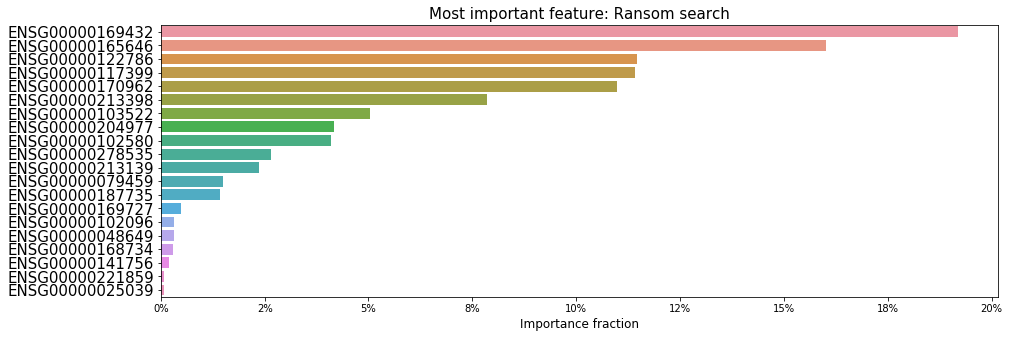

In [17]:
random_feature_importances = [(list(X.columns)[i], random_reg_best.best_estimator_.feature_importances_[i])
                              for i in range(len(list(X.columns)))]
random_feature_importances.sort(key=itemgetter(1), reverse = True)
plot_importance(random_feature_importances, 20, 'Random search')

In [18]:
print(r2_score(y_test,random_y_pred))

-0.06205214738488052


#### Feature selection

Let's try to run the model again, but this time selecting only the most impacting features to save us some work and let's compare the results.

In [19]:
random_selected_features = [random_feature_importances[i][0]
                            for i in range(15)]
random_X_train_sel = X_train[random_selected_features]
random_X_test_sel = X_test[random_selected_features]

In [20]:
with parallel_backend('ipyparallel'):
    random_reg.fit(random_X_train_sel, y_train);

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/Users/Christopher/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend IPythonParallelBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed: 55.4min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 270.7min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 365.7min finished
/Users/Christopher/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [21]:
random_best_score_sel = random_reg.best_score_
random_best_parameters_sel = random_reg.best_params_
random_best_n_estimators_sel = random_best_parameters_sel.get('n_estimators')
random_best_criterion_sel = random_best_parameters_sel.get('criterion')
random_best_max_depth_sel = random_best_parameters_sel.get('max_depth')
random_best_min_samples_split_sel = random_best_parameters_sel.get('min_samples_split')
random_best_min_samples_leaf_sel = random_best_parameters_sel.get('min_samples_leaf')
random_best_max_features_sel = random_best_parameters_sel.get('max_features')
random_best_bootstrap_sel = random_best_parameters_sel.get('bootstrap')


print('Random search best_score: {:.5}'.format(random_best_score_sel))

print('Random best n_estimators: {}'.format(random_best_n_estimators_sel))
print('Random best criterion: {}'.format(random_best_criterion_sel))
print('Random best max_depth: {}'.format(random_best_max_depth_sel))
print('Random best min_samples_split: {}'.format(random_best_min_samples_split_sel))
print('Random best min_samples_leaf: {}'.format(random_best_min_samples_leaf_sel))
print('Random best max_features: {}'.format(random_best_max_features_sel))
print('Random best bootstrap: {}'.format(random_best_bootstrap_sel))

Random search best_score: -0.14501
Random best n_estimators: 4760
Random best criterion: mae
Random best max_depth: 45
Random best min_samples_split: 94
Random best min_samples_leaf: 20
Random best max_features: log2
Random best bootstrap: False


In [22]:
random_best_parameters_sel = {'n_estimators' : [random_best_n_estimators_sel],
                              'criterion' : [random_best_criterion_sel],
                              'max_depth' : [random_best_max_depth_sel],
                              'min_samples_split' : [random_best_min_samples_split_sel],
                              'min_samples_leaf' : [random_best_min_samples_leaf_sel],
                              'max_features' : [random_best_max_features_sel],
                              'bootstrap' : [random_best_bootstrap_sel]}

In [23]:
random_reg_best_sel = GridSearchCV(rf_reg,
                                   param_grid = random_best_parameters_sel,
                                   return_train_score = True,
                                   verbose = 3)

In [24]:
with parallel_backend('ipyparallel'):
    random_reg_best_sel.fit(random_X_train_sel, y_train);

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/Christopher/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend IPythonParallelBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 43.9min finished


In [25]:
random_y_pred_sel = random_reg_best_sel.predict(random_X_test_sel)

In [26]:
mae = abs(random_y_pred_sel - y_test)/y_test
print("Accuracy: {:.2%}".format(1 - np.mean(mae)))

Accuracy: -98.76%


In [27]:
print(r2_score(y_test,random_y_pred_sel))

-0.06177922873395203
